<div style="text-align: center;">
    <img src="attachment:49087f40-2e3b-4363-9836-2577e28958e8.png" width="900" />
</div>


 # Introduction to BERT
The BERT model, which stands for Bidirectional Encoder Representations from Transformers, represents a groundbreaking shift in how natural language processing (NLP) tasks are approached. Developed by Google AI Language in 2018, BERT has revolutionized the field of NLP by delivering state-of-the-art performance on a wide array of tasks.

Bidirectional Training: Unlike traditional NLP models that process text in a single direction (left-to-right or right-to-left), BERT analyzes text in both directions simultaneously. This bidirectionality allows the model to understand the context of a word based on its entire surrounding text, leading to a richer understanding of language.

### Pre-training and Fine-tuning: BERT's training process comprises two stages:

1. Pre-training: BERT is initially trained on a large corpus of text with two unsupervised tasks: Masked Language Model (MLM) and Next Sentence Prediction (NSP).
2. Fine-tuning: The pre-trained BERT model is then fine-tuned for specific NLP tasks by continuing the training on task-specific datasets. **This is what we will do**

 <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*-geItI1s39NldRsGgqueGA.png" width="1000px" />

**Notebook link** https://www.kaggle.com/code/salehbinsuwaylih/bert-text-classification

## Importing Libraries

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import  Dense,Dropout
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow.keras.metrics import Precision, Recall , SparseCategoricalAccuracy 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
import matplotlib.patches as mpatches # needed for waffle Charts
from pywaffle import Waffle

2024-03-04 03:51:23.059810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 03:51:23.059950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 03:51:23.176774: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/human-vs-ai-text-classification-feb2024/train.csv')
df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [4]:
df.shape

(341064, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341064 entries, 0 to 341063
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       341064 non-null  object
 1   generated  341064 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.2+ MB


## EDA 

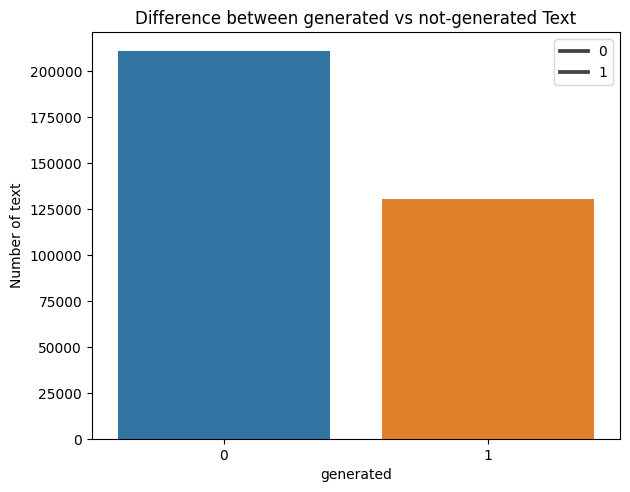

In [6]:
diff_of_gen = df.groupby(df['generated'])['text'].count().reset_index()

sns.barplot(x=diff_of_gen['generated'],y=diff_of_gen['text'])
plt.tight_layout()
plt.legend(diff_of_gen['generated'])
plt.title('Difference between generated vs not-generated Text')
plt.ylabel('Number of text')
plt.show()

In [7]:
diff_of_gen

,generated,text
0,0,210785
1,1,130279


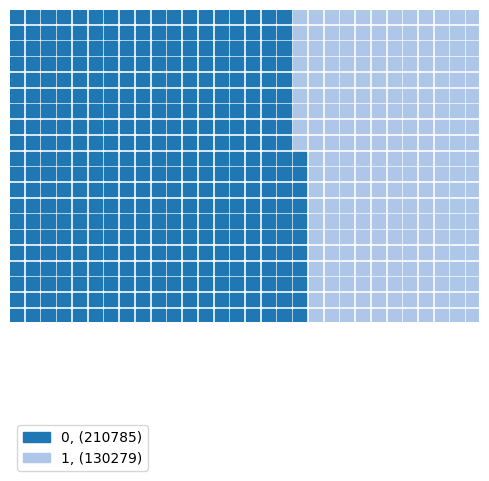

In [8]:
fig = plt.figure(FigureClass = Waffle,
                 rows = 20, columns = 30, #pass the number of rows and columns for the waffle 
                 values = diff_of_gen['text'], #pass the data to be used for display
                 cmap_name = 'tab20', #color scheme
                 legend = {'labels': [f"{k}, ({v})" for k, v in zip(diff_of_gen.generated.values,diff_of_gen.text)],
                            'loc': 'lower left', 'bbox_to_anchor':(0,-0.5),'ncol': 1}
                 #notice the use of list comprehension for creating labels 
                 #from index and total of the dataset
                )

#Display the waffle chart
plt.show()

In [9]:
text_gen = ' '.join(df[df['generated']==1]['text'])[0:df.shape[0]]
text_not_gen = ' '.join(df[df['generated']==0]['text'])[0:df.shape[0]]


In [10]:
text_cloud_gen = WordCloud().generate(text_gen)
text_cloud_not_gen = WordCloud().generate(text_not_gen)

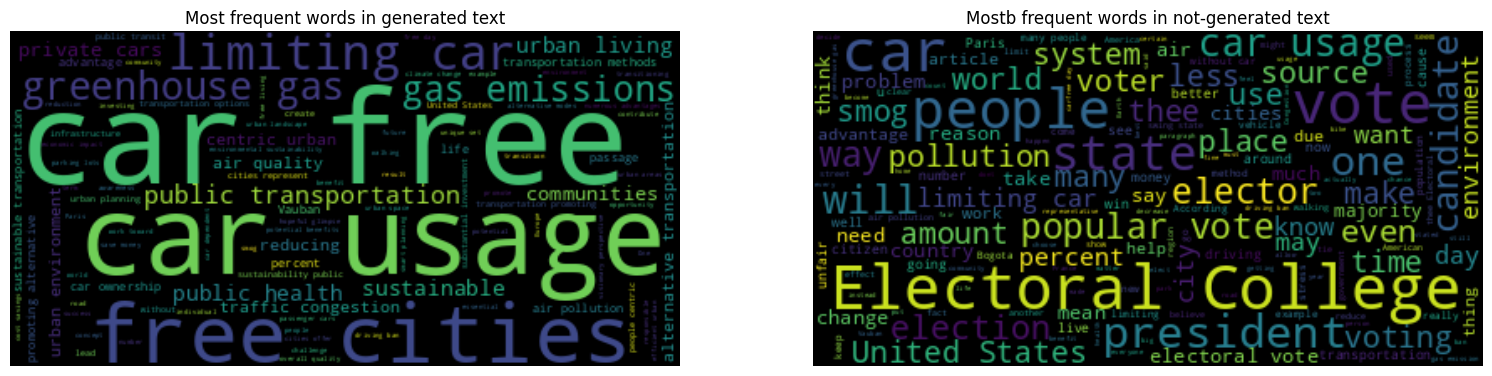

In [11]:
plt.figure(figsize=(19,10))

plt.subplot(2,2,1)
plt.title('Most frequent words in generated text')
plt.imshow(text_cloud_gen, interpolation='bilinear')
plt.axis('off')

plt.subplot(2,2,2)
plt.title('Mostb frequent words in not-generated text')
plt.imshow(text_cloud_not_gen, interpolation='bilinear')
plt.axis('off')

plt.show()

## Split the data

In [12]:
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['generated'], test_size=0.2, random_state=42)

In [13]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape )

(272851,) (68213,) (272851,) (68213,)


## Modeling 
Preprocessing Handled by BERT
Tokenization: BERT uses its own tokenizer to convert raw text into tokens. This process involves splitting the text into words, subwords, or characters that can be found in its vocabulary. For instance, words not found in the vocabulary are broken down into smaller subwords. This allows BERT to handle a wide range of vocabulary without significantly increasing its size.

Adding Special Tokens: BERT requires specific formatting of the input text, including special tokens like [CLS] at the beginning of each sequence and [SEP] to separate segments or mark the end of a sequence. Its tokenizer automatically handles the insertion of these tokens.

Segmentation and Positional Embeddings: The model adds segmentation and positional embeddings to distinguish between different sentences and the position of tokens within the sentence, respectively. This is part of BERT's architecture and is managed internally.

In [14]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)


Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...


**trainable=False** , instructing TensorFlow not to update the weights of those layers during the training process.

In [15]:
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/4",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-l-12-h-768-a-12/4' to your Kaggle notebook...


# Fine-tuning

### model construction 

In [16]:
l = tf.keras.layers.Dense(128, activation='relu', name='h1')(pooled_output)
l = tf.keras.layers.Dense(64, activation='relu',name='h2')(l)
l = tf.keras.layers.Dense(32, activation='relu', name='h3')(l)
l = tf.keras.layers.Dense(16, activation='relu', name='h4')(l)
l =tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

In [17]:
model=tf.keras.Model(inputs=[text_input],outputs=[l])

In [18]:
# Compile the model

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',Precision(), Recall()])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['input_1[0][0]']             
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

## Train the last layers

In [20]:
hist = model.fit(X_train, y_train, epochs=5,batch_size=32 ,validation_data=(X_val, y_val))

Epoch 1/5


I0000 00:00:1709524349.180127      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8527/8527 [==============================] - 2389s 279ms/step - loss: 0.2323 - accuracy: 0.9068 - precision: 0.8933 - recall: 0.8580 - val_loss: 0.1749 - val_accuracy: 0.9327 - val_precision: 0.9028 - val_recall: 0.9247
Epoch 2/5
8527/8527 [==============================] - 2377s 279ms/step - loss: 0.1783 - accuracy: 0.9312 - precision: 0.9217 - recall: 0.8957 - val_loss: 0.1581 - val_accuracy: 0.9403 - val_precision: 0.9380 - val_recall: 0.9047
Epoch 3/5
8527/8527 [==============================] - 2373s 278ms/step - loss: 0.1569 - accuracy: 0.9394 - precision: 0.9318 - recall: 0.9075 - val_loss: 0.1991 - val_accuracy: 0.9180 - val_precision: 0.8376 - val_recall: 0.9761
Epoch 4/5
8527/8527 [==============================] - 2376s 279ms/step - loss: 0.1445 - accuracy: 0.9449 - precision: 0.9372 - recall: 0.9170 - val_loss: 0.1230 - val_accuracy: 0.9542 - val_precision: 0.9650 - val_recall: 0.9142
Epoch 5/5
8527/8527 [==============================] - 2373s 278ms/step - loss: 0.1370 - a

## Evaluating the model

In [21]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

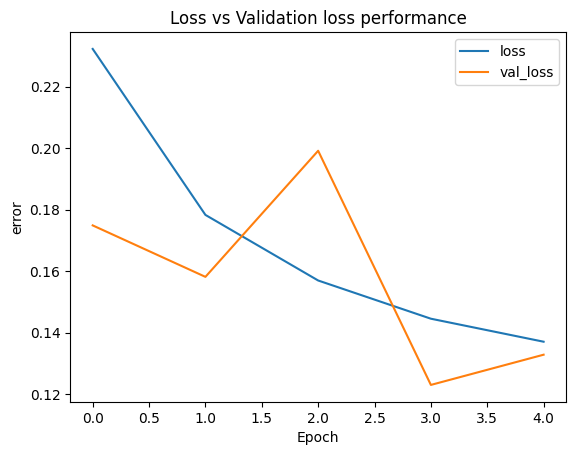

In [22]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('Loss vs Validation loss performance')
plt.xlabel('Epoch')
plt.ylabel('error')
plt.show()

In [23]:
model.evaluate(X_val, y_val)

2132/2132 [==============================] - 473s 222ms/step - loss: 0.1328 - accuracy: 0.9493 - precision: 0.9258 - recall: 0.9439


[0.1327860951423645, 0.9492911696434021, 0.9258304238319397, 0.943851888179779]

In [24]:
y_predict=model.predict(X_val)
y_pred=np.where(y_predict>0.5,1,0)

2132/2132 [==============================] - 469s 220ms/step


In [25]:
cr = classification_report(y_val, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     41961
           1       0.93      0.94      0.93     26252

    accuracy                           0.95     68213
   macro avg       0.95      0.95      0.95     68213
weighted avg       0.95      0.95      0.95     68213



In [26]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the confusion matrix
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[39976  1985]
 [ 1474 24778]]


# Submission

In [27]:
submm_df = pd.read_csv('/kaggle/input/human-vs-ai-text-classification-feb2024/sample_submission.csv')
test_df = pd.read_csv("/kaggle/input/human-vs-ai-text-classification-feb2024/test.csv")

In [28]:
test = test_df['text']

In [29]:
y_predict_test = model.predict(test)
y_pred_test = np.where(y_predict_test>0.5,1,0)

2706/2706 [==============================] - 594s 220ms/step


In [30]:
# Create a submission DataFrame
submm_df['Id'] = test_df['Id']
submm_df['generated'] = y_pred_test

# Save the submission file
submm_df.to_csv('submission.csv', index=False)